In [1]:
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time

In [2]:
#parameters
from scipy.io import loadmat
stocks = loadmat('data/data_490_1000.mat')

stocks_shape = stocks['A'].shape
number_of_stocks = stocks_shape[0]
number_of_trades = stocks_shape[1]
num_of_simulations = 1

In [3]:
#calculating the loss
def loss(x, r_t):
    return -np.log(np.dot(x, r_t))

# revanue in time t
def revanue(x, r_t, wealth):
    temp = wealth* (np.dot(np.transpose(x), r_t))
    return temp

# normalize vector
def normalize_func(x):
    sum_x = np.sum(x)
    x = x/sum_x
    return x

# gradient vector
def gradient(x, r_t):
    temp = -1/np.dot(np.transpose(r_t), x)
    temp = np.dot(temp,np.transpose(r_t))
    return temp

def gradient2(x, r_t, r_matrix, i):
    temp = -1/np.dot(np.transpose(r_matrix[:,:i]), x)
    temp = np.dot(temp,np.transpose(r_matrix[:,:i]))
    return temp

#get r materix
def get_r_matrix(number_of_stocks, number_of_trades, stocks):
    r_matrix = np.zeros([number_of_stocks, number_of_trades-1])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades-1):
            r_matrix[stock][trade] = (stocks['A'][stock][trade + 1])/(stocks['A'][stock][trade])
    return r_matrix

#simplex projection
def proj(temp_x, number_of_stocks):
    y_flipsort = np.flipud(np.sort(temp_x))
    cumsum = np.cumsum(y_flipsort)
    t = (cumsum - 1) / np.arange(1, number_of_stocks + 1).astype('float')
    temp_t = t[:-1]
    y_iter = y_flipsort[1:]
    if np.all((temp_t - y_iter) < 0):
        x = temp_x - t[-1]
    else:
        x = temp_x - temp_t[np.searchsorted(temp_t - y_iter, 0, side='left')]
    x[x < 0.] = 0.
    sum_x = np.sum(x)
    x = x/sum_x
    return x

#plot
def plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations):
    if final_OGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_OGD /  num_of_simulations, 'green')
    if final_EGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_EGD /  num_of_simulations, 'red')
    if final_ONS is not 0:
        plt.plot(range(1, number_of_trades+1), final_ONS /  num_of_simulations, 'blue')
    if final_rebalnce is not 0:
        plt.plot(range(1, number_of_trades+1), final_rebalnce /  num_of_simulations, 'grey')
    if final_fixed_stock is not 0:
        plt.plot(range(1, number_of_trades+1), final_fixed_stock /  num_of_simulations, 'black')

    plt.legend(['OGD', 'EGD', 'ONS'
                , 'final_rebalnce', 'final_fixed_stock'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Wealth')
    plt.xlabel('number_of_trades')
    plt.title('ORPS methods comparison')
    plt.savefig('ORPS methods comparison.png')
    plt.show()

In [4]:
#fixed stock func
def fixed_stock_func(number_of_stocks, number_of_trades, r_matrix):
    all_stocks_wealth = np.zeros([number_of_stocks, number_of_trades])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades):
            if (trade == 0):
                all_stocks_wealth[stock][trade] = 1
                continue
            all_stocks_wealth[stock][trade] = all_stocks_wealth[stock][trade-1] * r_matrix[stock][trade-1]
    max = None
    index = None
    for stock in range(number_of_stocks):
        if ((max == None) or (all_stocks_wealth[stock][number_of_trades-1]>max)):
            max = all_stocks_wealth[stock][number_of_trades-1]
            index = stock    
    return all_stocks_wealth[index, :]

In [5]:
#Online_gradient_descent
def Online_gradient_descent(x, r_matrix, number_of_trades, step):
    scores_OGD = np.zeros(number_of_trades)
    scores_OGD[0] = 1
    scores_OGD[1] = revanue(x, r_matrix[:,0], scores_OGD[0])
    for i in range(2, number_of_trades):
        x = x - step * gradient(x,r_matrix[:,i-2])
#         x = x - step * gradient2(x,r_matrix[:,i-2],r_matrix, i-1)
        x = proj(x, number_of_stocks)
        scores_OGD[i] = revanue(x, r_matrix[:,i-1], scores_OGD[i-1])
    return scores_OGD

In [6]:
#denominator of the equation
def exp_stocks_t(x, rt, number_of_stocks, step, grad):
    sum = 0
    for stock in range(number_of_stocks):
        sum += x[stock]* np.exp(-step*grad[stock])
    return sum

#Online Exponentiated Gradient
def Online_Exponentiated_Gradient(x, r_matrix, number_of_trades, number_of_stocks, step):
    scores_OEG = np.zeros(number_of_trades)
    scores_OEG[0] += 1
    scores_OEG[1] = revanue(x, r_matrix[:,0], scores_OEG[0])
    for i in range(2, number_of_trades):
        grad = gradient(x,r_matrix[:,i-2])
#         grad = gradient2(x,r_matrix[:,i-2],r_matrix, i-1)
        denominator = exp_stocks_t(x, r_matrix[:,i-2], number_of_stocks, step, grad)
        for stock in range(number_of_stocks): 
            x[stock] = (x[stock] * np.exp(-step * grad[stock])) / denominator
        x = proj(x, number_of_stocks)
        scores_OEG[i] += revanue(x, r_matrix[:,i-1], scores_OEG[i-1])
    return scores_OEG

In [12]:
#projection on yt+1
def projection(A, eta_min, y, number_of_stocks):
    I = np.eye(number_of_stocks, dtype=np.float32)
    x = I[0]
    for t in range(1, number_of_stocks + 1):
        eta = 2 / (1 + t)
        if eta < eta_min:
            break
        i_min = np.argmin(2 * np.dot(A, x - y))
        x += eta * (I[i_min] - x)
    return x


#online_newton_step
def online_newton_step(number_of_trades, number_of_stocks, r_matrix, x, D, G):
    scores_ONS = np.zeros(number_of_trades)
    scores_ONS[0] += 1
    gamma = 0.5 *  (1 / (4 * G * D))
    epsilion = 1 / ((gamma ** 2) * (D**2))
    A = epsilion * np.eye(number_of_stocks)
    Ainv = (1 / epsilion) * np.eye(number_of_stocks)
    for trade in range(1, number_of_trades):
        r_t = r_matrix[ : , trade - 1]
        scores_ONS[trade] = revanue(x, r_t, scores_ONS[trade-1])
        grad = gradient(x,r_t)
        grad_matrix = np.outer(grad, grad)
        A = A + grad_matrix
        Ainv = Ainv - (np.dot(Ainv, np.dot(grad_matrix, Ainv)) / (1 + np.dot(grad, np.dot(Ainv, grad))))
        yt = x - (1 / gamma) * np.dot(Ainv, grad)
        eta_min = 0.01
        x = projection(A, eta_min, yt, number_of_stocks)
    return scores_ONS

In [14]:
def grad_rebalnce(R, x):
    instence_number_of_trades,temp = R.shape
    a = np.dot(R, x)
    a = - 1 / a
    a = np.reshape(a, (instence_number_of_trades, -1))
    return np.sum(R * a, axis=0)

def fit(R, number_of_stocks, number_of_trades, max_iter, eta_min):
    I = np.eye(number_of_stocks, dtype=np.float32)
    x = I[0]
    for t in range(1, max_iter + 1):
        eta = 2 / (1 + t)
        if eta < eta_min:
            break
        i_min = np.argmin(grad_rebalnce(R, x))
        x += eta * (I[i_min] - x)
    return x        

def rebalnce_solution(number_of_trades, r_matrix, number_of_stocks):
    max_iter = 25
    eta_min=0.
    R = np.transpose(r_matrix)
    x = np.empty_like(R)
    for t in range(R.shape[0]):
        x[t] = fit(R[0:t+1], number_of_stocks, number_of_trades, max_iter, eta_min)
    x = x[-1]
    return x

def rebalnce_score(x, number_of_trades, r_matrix):
    score = np.zeros(number_of_trades)
    score[0] = 1
    for trade in range (1, number_of_trades):
        score[trade] = score[trade-1] * np.dot(x, r_matrix[:,trade-1])
    return score

100%|██████████| 1/1 [00:51<00:00, 51.97s/it]


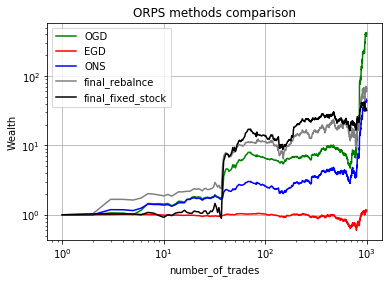

In [16]:
final_OGD = np.zeros(number_of_trades)
final_EGD = np.zeros(number_of_trades)
final_ONS = np.zeros(number_of_trades)
final_rebalnce = np.zeros(number_of_trades)
final_fixed_stock = np.zeros(number_of_trades)
for i in tqdm(range(num_of_simulations),total=num_of_simulations):
    x = np.random.uniform(0,10,number_of_stocks)
    x = normalize_func(x)
    r_matrix = get_r_matrix(number_of_stocks, number_of_trades, stocks)
    T = number_of_trades
    D = math.sqrt(2)
    G = np.max(np.linalg.norm(np.transpose(r_matrix), axis=1) / np.sum(np.transpose(r_matrix), axis=1))
    OGD_step = D / (G * math.sqrt(T))
    OEG_step = D / (G * math.sqrt(2*T))

    OGD = Online_gradient_descent(x, r_matrix, number_of_trades, OGD_step)
    EGD = Online_Exponentiated_Gradient(x, r_matrix, number_of_trades, number_of_stocks, OEG_step)
    ONS = online_newton_step(number_of_trades, number_of_stocks, r_matrix, x, D, G)
    temp_x = rebalnce_solution(number_of_trades, r_matrix, number_of_stocks)
    rebalnce = rebalnce_score(temp_x, number_of_trades, r_matrix)
    fixed_stock = fixed_stock_func(number_of_stocks, number_of_trades, r_matrix)
    
    final_OGD += OGD
    final_EGD += EGD
    final_ONS += ONS
    final_rebalnce += rebalnce
    final_fixed_stock += fixed_stock
    
plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations)